## In this notebook

- Create a model with memory.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.
- Used [this tutorial](https://towardsdatascience.com/rnn-recurrent-neural-networks-how-to-successfully-model-sequential-data-in-python-5a0b9e494f92).

In [1]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score,
)
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, SimpleRNN

# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No such file or directory']
  warnings.warn(f"file system plugin

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
DATA_FOLDER = "../data"

TIMESTEP = 8
Y_COLUMN = "available"

In [4]:
! ls -l $DATA_FOLDER

total 181500
-rw-rw-r-- 1 nobody nogroup  14095077 Aug  4 08:41 test.csv
-rw-rw-r-- 1 nobody nogroup 171754453 Aug  4 08:41 train.csv


## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*95*1,0,0,0,3,95,5,22202,48.86851,2.295469,75016,west
1851079,2021-02-18 23:45:00,FR*V75*EBELI*96*1,2,1,0,0,95,5,22202,48.83550,2.349650,75013,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*97*1,1,1,1,0,95,5,22202,48.83995,2.397822,75012,east
1851081,2021-02-18 23:45:00,FR*V75*EBELI*98*1,2,0,1,0,95,5,22202,48.84998,2.361920,75004,south
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


In [6]:
# leave only one target in the data set

df = df.loc[:, ["date", "station", Y_COLUMN]]
df = df.sort_values(by="date").reset_index(drop=True)

df.tail()

,date,station,available
1851078,2021-02-18 23:45:00,FR*V75*EBELI*32*1,3
1851079,2021-02-18 23:45:00,FR*V75*EBELI*31*1,2
1851080,2021-02-18 23:45:00,FR*V75*EBELI*30*1,2
1851081,2021-02-18 23:45:00,FR*V75*EBELI*39*1,1
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3


## Prepare data for model

#### 1st option

- Reshape data into `TIMESTEP` long sequences.
- It leads to loosing a lot of data points.
- Example `TIMESTEP = 4`:

```
+-----------------------+-------+
| X                     | y     |
+-----------------------+-------+
| x_1, x_2, x_3, x_4    | x_5   |
| x_5, x_6, x_7, x_8    | x_9   |
| x_9, x_10, x_11, x_12 | x_13  |
+-----------------------+-------+
```

In [7]:
%%time 

for i, station in enumerate(df.station.unique()):
    target_col_series = (
        df
        .loc[df.station == station, Y_COLUMN]
    )
    values_to_drop_cnt = (len(target_col_series) % TIMESTEP) * -1
    
    x_array = (
        target_col_series
        .head(values_to_drop_cnt)
        .values
        .reshape(-1, TIMESTEP)
    )
    
    if i == 0:
        X = x_array[:-1, :]
        y = x_array[1:, 0]
        continue

    X = np.append(X, x_array[:-1, :], axis=0)
    y = np.append(y, x_array[1:, 0])    

print(X.shape)
print(y.shape)

(217688, 8)
(217688,)
CPU times: user 5.55 s, sys: 1.95 ms, total: 5.56 s
Wall time: 5.55 s


#### 2nd option

- Reshape data into `TIMESTEP` long slided windows.
- It leads to preserving all the data points.
- Example `TIMESTEP = 4`:

```
+-----------------------+-------+
| X                     | y     |
+-----------------------+-------+
| x_1, x_2, x_3, x_4    | x_5   |
| x_2, x_3, x_4, x_5    | x_6   |
| x_3, x_4, x_5, x_6    | x_7   |
+-----------------------+-------+
```

In [8]:
%%time

"""
window_size = TIMESTEP + 1

for i, station in enumerate(df.station.unique()):
    target_col_array = (
        df
        .loc[df.station == station, Y_COLUMN]
        .values
    )
    
    rows = []
    for j in range(len(target_col_array) - window_size + 1):
        rows.append(
            target_col_array[j: j + window_size]
        )
        
    x_array = np.array(rows)
    
    if i == 0:
        X = x_array[:, :-1]
        y = x_array[:, -1]
        continue

    X = np.append(X, x_array[:, :-1], axis=0)
    y = np.append(y, x_array[:, -1])
    
    # break
    
print(X.shape)
print(y.shape)
"""

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


'\nwindow_size = TIMESTEP + 1\n\nfor i, station in enumerate(df.station.unique()):\n    target_col_array = (\n        df\n        .loc[df.station == station, Y_COLUMN]\n        .values\n    )\n    \n    rows = []\n    for j in range(len(target_col_array) - window_size + 1):\n        rows.append(\n            target_col_array[j: j + window_size]\n        )\n        \n    x_array = np.array(rows)\n    \n    if i == 0:\n        X = x_array[:, :-1]\n        y = x_array[:, -1]\n        continue\n\n    X = np.append(X, x_array[:, :-1], axis=0)\n    y = np.append(y, x_array[:, -1])\n    \n    # break\n    \nprint(X.shape)\nprint(y.shape)\n'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build model

In [10]:
# run model

# specify the architecture of RNN
model = Sequential(name="First-RNN-Model")
model.add(Input(shape=(TIMESTEP, 1), name="Input-Layer")) 
model.add(SimpleRNN(units=1, activation="tanh", name="Hidden-Recurrent-Layer"))
model.add(Dense(units=1, activation="tanh", name="Hidden-Layer")) 
model.add(Dense(units=1, activation="linear", name="Output-Layer"))

# compile the model
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["MeanSquaredError", "MeanAbsoluteError"],
    loss_weights=None,
    run_eagerly=None,
    steps_per_execution=None
)

# fit model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10, 
    validation_split=0.0,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/10
5443/5443 [==============================] - 6s 952us/step - loss: 0.4760 - mean_squared_error: 0.4760 - mean_absolute_error: 0.4314
Epoch 2/10
5443/5443 [==============================] - 5s 944us/step - loss: 0.2077 - mean_squared_error: 0.2077 - mean_absolute_error: 0.2436
Epoch 3/10
5443/5443 [==============================] - 5s 984us/step - loss: 0.2030 - mean_squared_error: 0.2030 - mean_absolute_error: 0.2345
Epoch 4/10
5443/5443 [==============================] - 5s 955us/step - loss: 0.2013 - mean_squared_error: 0.2013 - mean_absolute_error: 0.2309
Epoch 5/10
5443/5443 [==============================] - 5s 930us/step - loss: 0.2006 - mean_squared_error: 0.2006 - mean_absolute_error: 0.2286
Epoch 6/10
5443/5443 [==============================] - 5s 928us/step - loss: 0.2001 - mean_squared_error: 0.2001 - mean_absolute_error: 0.2285
Epoch 7/10
5443/5443 [==============================] - 5s 929us/step - loss: 0.1999 - mean_squared_error: 0.1999 - mean_absolute_error:

## Validate model

In [11]:
# check performance on test dataset

y_test_pred = np.round(model.predict(X_test).reshape(1, -1)[0])

print("Results:")
print(f"- accuracy: {accuracy_score(y_test, y_test_pred):,.3f}")
print(f"- precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):,.3f}")
print(f"- recall: {recall_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):,.3f}")
print()
print(f"- confusion matrix: \n{confusion_matrix(y_test, y_test_pred)}")

1361/1361 [==============================] - 1s 603us/step
Results:
- accuracy: 0.882
- precision: 0.884
- recall: 0.882
- F1: 0.883

- confusion matrix: 
[[ 9597   318   133   232]
 [  194  4091   794    65]
 [   64   854  9939   990]
 [   59   204  1241 14763]]


<AxesSubplot: >

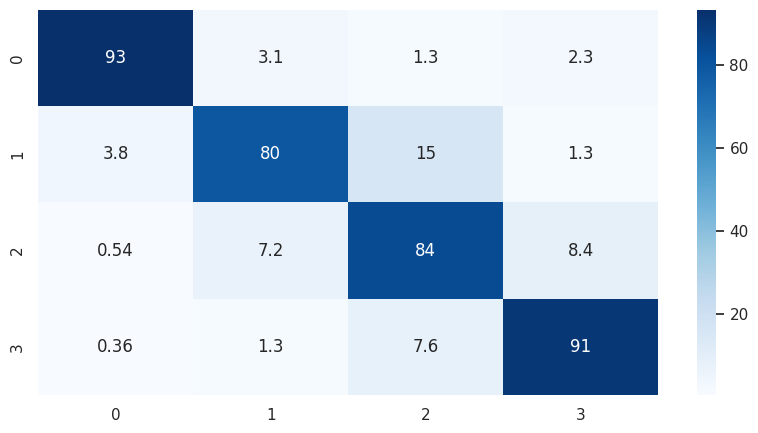

In [12]:
# check confusion matrix (with shares in every true class=rows)

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm / cm.sum(axis=1).reshape(-1, 1) * 100, 
    annot=True,
    cmap='Blues',
)

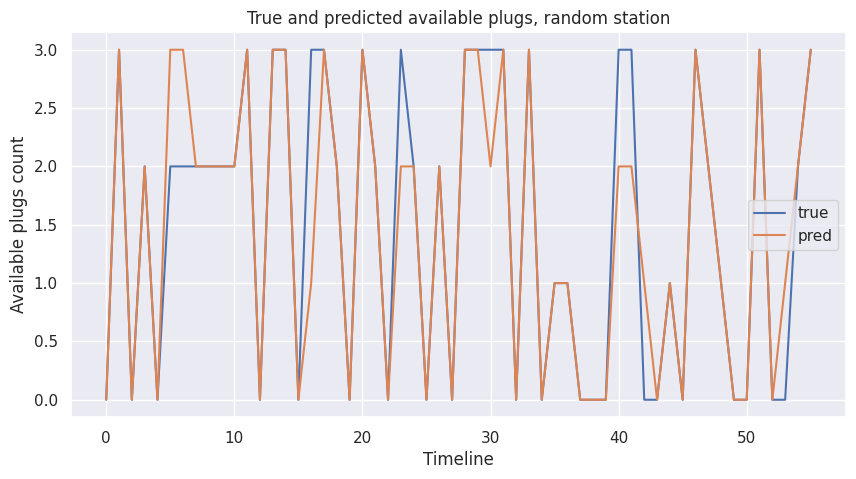

In [13]:
# check comparison of true and predicted available plugs

df_results = pd.DataFrame({
    "true": y_test,
    "pred": y_test_pred,
})

# ax = df_results.plot(alpha=0.75)
ax = df_results.head(96).plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs, random station, 1 day")

plt.show()

## Try to predict one station for the next 7 days

In [14]:
DATA_POINTS_TO_PREDICT = 96 * 7

In [15]:
%%time

most_frequent_station = df.station.value_counts().index[0]
last_values = (
    df
    .loc[df.station == most_frequent_station]
    .available
    .tail(TIMESTEP)
    .to_list()
)
preds = []

for i in range(DATA_POINTS_TO_PREDICT):
    if i > 0:
        last_values.pop(0)
        last_values.append(pred)
    
    pred = model.predict(np.array([last_values]), verbose=0)[0][0]
    preds.append(pred)

CPU times: user 17.2 s, sys: 478 ms, total: 17.7 s
Wall time: 16.1 s


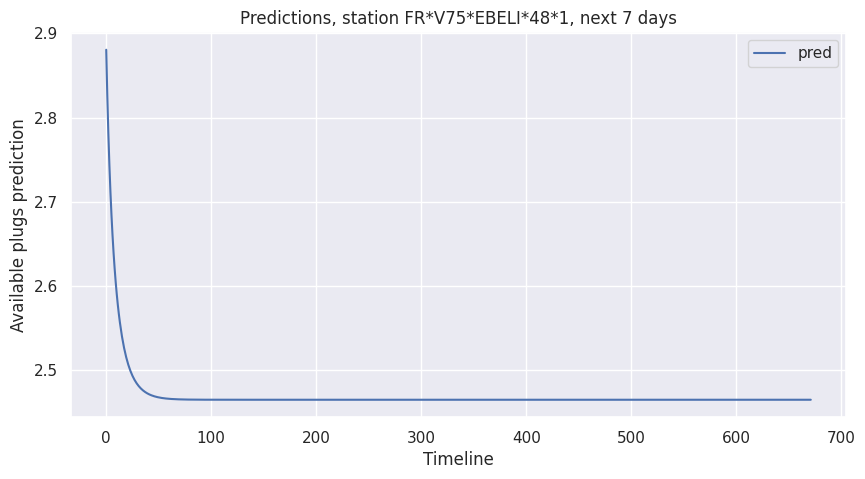

In [16]:
df_preds = pd.DataFrame({
    "pred": preds,
})

ax = df_preds.plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs prediction")
ax.set_title(f"Predictions, station {most_frequent_station}, next {DATA_POINTS_TO_PREDICT / 96:,.0f} days")

plt.show()

## Results

- Created a memory model.
- The results are following:
    - accuracy: 0.882
    - precision: 0.884
    - recall: 0.882
    - F1: 0.883    
- Model cannot be used for long term predictions, because it starts to converge to one value very quickly.